In [56]:
# Importação de Bibliotecas Necessárias
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import janitor
import plotly.graph_objs as go
import plotly.offline as py
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
warnings.filterwarnings('ignore')

In [57]:
df = pd.read_csv('churn_bank.csv').clean_names()
df.head()

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [58]:
def dataoveriew(df, message):
    print(f'{message}:\n')
    print("Rows:", df.shape[0])
    print("\nNumber of features:", df.shape[1])
    print("\nFeatures:")
    print(df.columns.tolist())
    print("\nMissing values:", df.isnull().sum().values.sum())
    print("\nUnique values:")
    print(df.nunique())
    print("\nData types:")
    print(df.dtypes)

In [59]:
dataoveriew(df, 'Overiew of the dataset')

Overiew of the dataset:

Rows: 10000

Number of features: 14

Features:
['rownumber', 'customerid', 'surname', 'creditscore', 'geography', 'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary', 'exited']

Missing values: 0

Unique values:
rownumber          10000
customerid         10000
surname             2932
creditscore          460
geography              3
gender                 2
age                   70
tenure                11
balance             6382
numofproducts          4
hascrcard              2
isactivemember         2
estimatedsalary     9999
exited                 2
dtype: int64

Data types:
rownumber            int64
customerid           int64
surname             object
creditscore          int64
geography           object
gender              object
age                  int64
tenure               int64
balance            float64
numofproducts        int64
hascrcard            int64
isactivemember       int64
estimatedsa

# Análise Exploratória de Dados

In [60]:
# Certifique-se de que a contagem de 'geography' esteja correta
geography_counts = df['geography'].value_counts()
# Trace do gráfico
trace = go.Bar(x=geography_counts.index,
               y=geography_counts.values,
               marker=dict(color=geography_counts.values,
                           colorscale='Viridis',
                           showscale=True),
               text=geography_counts.index)

data = [trace]
layout = go.Layout(barmode="group", title=dict(text='Distribuição Geográfica dos Clientes', x=0.5))
fig = go.Figure(data=data, layout=layout)

# Plotar o gráfico
py.iplot(fig)

In [61]:
# Função para calcular porcentagens
def calculate_percent(df, group_by, column):
    distribution = df.groupby([group_by, column]).size().unstack(fill_value=0)
    percent_distribution = distribution.div(distribution.sum(axis=1), axis=0) * 100
    return percent_distribution

# Calcular porcentagens para geografia, gênero, faixas etárias, tenure e balance
churn_by_geography = calculate_percent(df, 'geography', 'exited')
churn_by_gender = calculate_percent(df, 'gender', 'exited')

# Categorizar a idade em faixas etárias
df['age_group'] = pd.cut(df['age'], bins=[18, 30, 40, 50, 60, 70, 80, 90], right=False)
churn_by_age_group = calculate_percent(df, 'age_group', 'exited')

# Categorizar balance em faixas
df['balance_group'] = pd.cut(df['balance'], bins=[0, 25000, 50000, 75000, 100000, 125000, 150000, 175000, 200000], right=False)
churn_by_balance = calculate_percent(df, 'balance_group', 'exited')

# Calcular porcentagens para tenure
churn_by_tenure = calculate_percent(df, 'tenure', 'exited')

# Função para criar trace
def create_trace(group, percent_distribution, exited_status, color, name_suffix):
    return go.Bar(
        x = percent_distribution.index.astype(str),
        y = percent_distribution[exited_status],
        name = f'{exited_status} {name_suffix}',
        marker=dict(color=color),
        text = percent_distribution[exited_status].round(2),
        textposition = 'auto'
    )

# Criar traces
trace_geo_not_exited = create_trace('geography', churn_by_geography, 0, 'rgb(158,202,225)', '(Geography)')
trace_geo_exited = create_trace('geography', churn_by_geography, 1, 'rgb(255,127,14)', '(Geography)')

trace_gender_not_exited = create_trace('gender', churn_by_gender, 0, 'rgb(158,202,225)', '(Gender)')
trace_gender_exited = create_trace('gender', churn_by_gender, 1, 'rgb(255,127,14)', '(Gender)')

trace_age_not_exited = create_trace('age_group', churn_by_age_group, 0, 'rgb(158,202,225)', '(Age Group)')
trace_age_exited = create_trace('age_group', churn_by_age_group, 1, 'rgb(255,127,14)', '(Age Group)')

trace_balance_not_exited = create_trace('balance_group', churn_by_balance, 0, 'rgb(158,202,225)', '(Balance)')
trace_balance_exited = create_trace('balance_group', churn_by_balance, 1, 'rgb(255,127,14)', '(Balance)')

trace_tenure_not_exited = create_trace('tenure', churn_by_tenure, 0, 'rgb(158,202,225)', '(Tenure)')
trace_tenure_exited = create_trace('tenure', churn_by_tenure, 1, 'rgb(255,127,14)', '(Tenure)')

# Layouts
layout_geo = go.Layout(
    barmode = 'group',
    title = dict(text='Churn Distribution by Geography', x=0.5),
    xaxis = dict(title = 'Geography'),
    yaxis = dict(title = 'Percentage')
)

layout_gender = go.Layout(
    barmode = 'group',
    title = dict(text='Churn Distribution by Gender', x=0.5),
    xaxis = dict(title = 'Gender'),
    yaxis = dict(title = 'Percentage')
)

layout_age = go.Layout(
    barmode = 'group',
    title = dict(text='Churn Distribution by Age Group', x=0.5),
    xaxis = dict(title = 'Age Group'),
    yaxis = dict(title = 'Percentage')
)

layout_balance = go.Layout(
    barmode = 'group',
    title = dict(text='Churn Distribution by Balance', x=0.5),
    xaxis = dict(title = 'Balance Group'),
    yaxis = dict(title = 'Percentage')
)

layout_tenure = go.Layout(
    barmode = 'group',
    title = dict(text='Churn Distribution by Tenure', x=0.5),
    xaxis = dict(title = 'Tenure'),
    yaxis = dict(title = 'Percentage')
)

# Figuras
fig_geo = go.Figure(data = [trace_geo_not_exited, trace_geo_exited], layout = layout_geo)
fig_gender = go.Figure(data = [trace_gender_not_exited, trace_gender_exited], layout = layout_gender)
fig_age = go.Figure(data = [trace_age_not_exited, trace_age_exited], layout = layout_age)
fig_balance = go.Figure(data = [trace_balance_not_exited, trace_balance_exited], layout = layout_balance)
fig_tenure = go.Figure(data = [trace_tenure_not_exited, trace_tenure_exited], layout = layout_tenure)

# Mostrar gráficos
py.iplot(fig_geo)
py.iplot(fig_gender)
py.iplot(fig_age)
py.iplot(fig_balance)
py.iplot(fig_tenure)



In [62]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rownumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
customerid,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
creditscore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
numofproducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
hascrcard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
isactivemember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
estimatedsalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


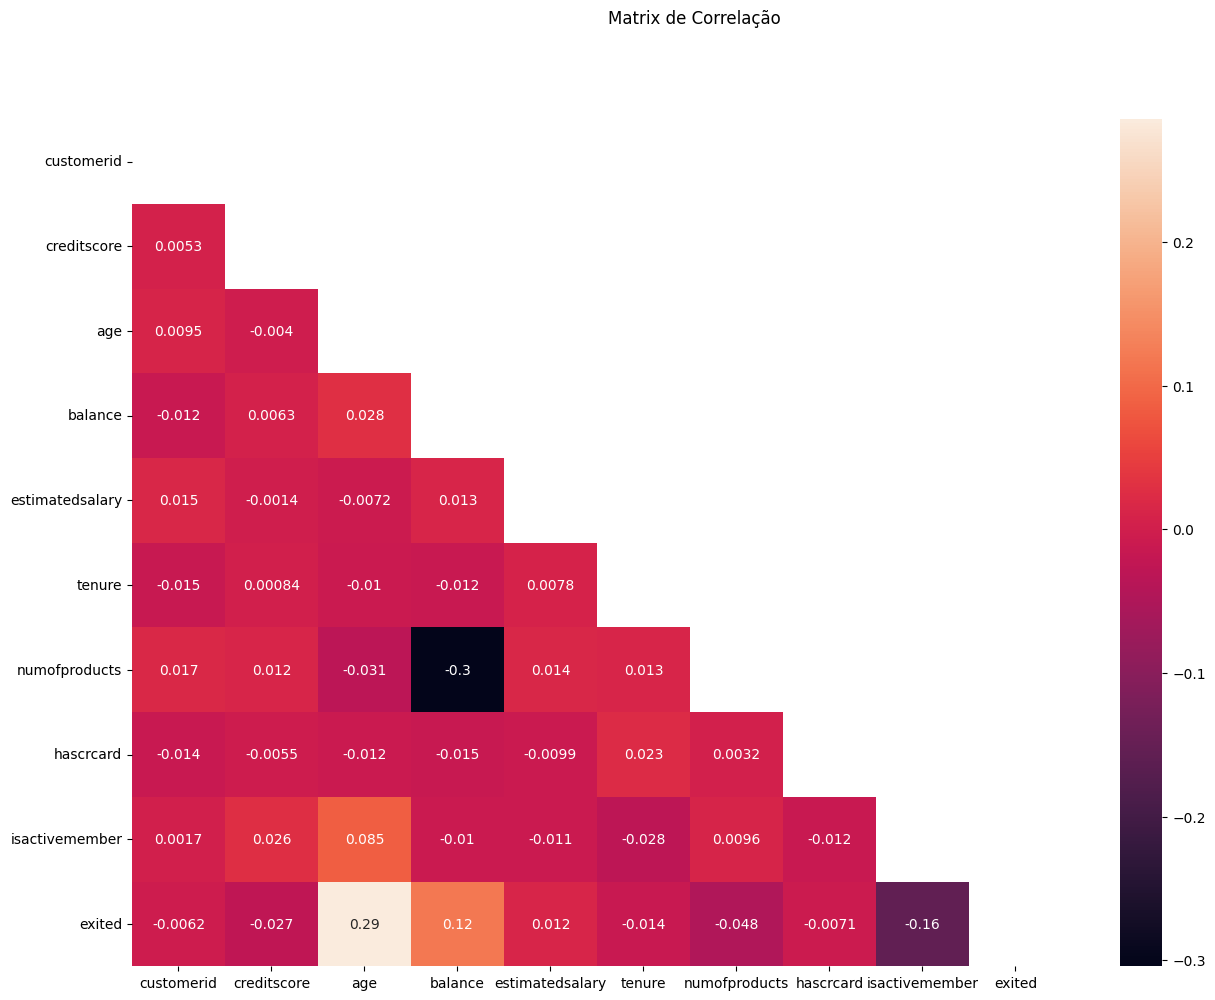

In [63]:
df_corr = df[['customerid', 'creditscore', 'age', 'balance', 'estimatedsalary', 
       'tenure', 'numofproducts', 'hascrcard', 'isactivemember', 'exited']].copy()
corr_matrix=df_corr.corr()

mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

f,ax=plt.subplots(figsize=(15,11))
sns.heatmap(corr_matrix, mask=mask, annot=True)
plt.suptitle('Matrix de Correlação')
plt.show()

# Preparação dos Dados

In [64]:
# Limpeza de Dados de dados
df.drop(columns=['rownumber', 'customerid', 'surname'], inplace=True)

In [65]:
"""
## Preparação dos Dados
Codificamos variáveis categóricas e escalamos variáveis numéricas.
"""
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features.remove('exited')

categorical_features = ['geography', 'gender']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

df_prepared = preprocessor.fit_transform(df)


# Feature Engineering

In [66]:

"""
## Feature Engineering
Introduzimos novas características para melhorar o modelo.
Aqui, criamos interações entre variáveis existentes e novas características derivadas para capturar efeitos combinados que podem ser importantes para a previsão.
"""

# Interação entre idade e número de produtos
df['age_products_interaction'] = df['age'] * df['numofproducts']

# Razão entre o tempo de permanência (tenure) e a idade
df['tenure_age_ratio'] = df['tenure'] / (df['age'] + 1)  # Adicionamos 1 para evitar divisão por zero

# Produto entre saldo e número de produtos, para ver se clientes com mais produtos tendem a ter saldos maiores
df['balance_products'] = df['balance'] * df['numofproducts']

# Log do salário estimado para normalizar a distribuição
df['log_estimated_salary'] = np.log(df['estimatedsalary'] + 1)  # Adicionamos 1 para evitar log de zero

# Normalizamos e adicionamos estas novas características ao nosso conjunto de dados preparado
additional_features = df[['age_products_interaction', 'tenure_age_ratio', 'balance_products', 'log_estimated_salary']]
additional_features_scaled = StandardScaler().fit_transform(additional_features)
df_prepared = np.hstack((df_prepared, additional_features_scaled))


# Modelagem

In [67]:
"""
## Modelagem
Testamos vários modelos para identificar o mais eficaz.
"""
X = df_prepared
y = df['exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'GBM': GradientBoostingClassifier(),
    'SVM': SVC()
}


In [68]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    results[name] = {
        'Accuracy': accuracy_score(y_test, predictions),
        'Precision': precision_score(y_test, predictions),
        'Recall': recall_score(y_test, predictions),
        'F1-Score': f1_score(y_test, predictions)
    }


Resultados dos Modelos de Classificação:
                     Accuracy  Precision    Recall  F1-Score
Logistic Regression    0.8220   0.619355  0.244275  0.350365
Decision Tree          0.7895   0.467890  0.519084  0.492159
KNN                    0.8480   0.674510  0.437659  0.530864
Random Forest          0.8635   0.736220  0.475827  0.578053
GBM                    0.8710   0.766798  0.493639  0.600619
SVM                    0.8585   0.805556  0.368957  0.506108


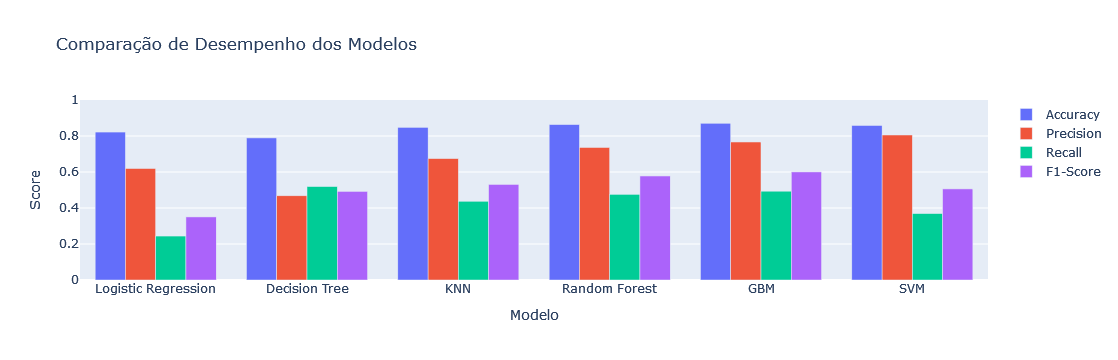

In [69]:
# Montagem do DataFrame de Resultados
results_df = pd.DataFrame(results).T

# Exibindo os Resultados em Formato de Tabela
print("Resultados dos Modelos de Classificação:")
print(results_df)

# Criando Gráficos para Comparação Visual dos Modelos com Plotly
def plot_model_performance(df):
    fig = go.Figure()
    for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
        fig.add_trace(go.Bar(
            x=df.index,
            y=df[metric],
            name=metric
        ))
    
    # Atualizando o layout do gráfico
    fig.update_layout(
        title='Comparação de Desempenho dos Modelos',
        xaxis_title='Modelo',
        yaxis_title='Score',
        barmode='group',
        yaxis=dict(range=[0, 1])  # Define o intervalo do eixo y para melhor visualização
    )
    
    return fig

# Chamando a função e mostrando o gráfico
plot_model_performance(results_df).show()

In [70]:
# Aplicação do PCA com retenção de 95% da variância
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [71]:
# Avaliação dos modelos ajustados com dados transformados por PCA
tuned_results_pca = {}
for model_name, model in best_models.items():
    # Treinando o modelo com dados transformados pelo PCA
    model.fit(X_train_pca, y_train)
    predictions_pca = model.predict(X_test_pca)

    # Calculando métricas de desempenho
    accuracy_pca = accuracy_score(y_test, predictions_pca)
    precision_pca = precision_score(y_test, predictions_pca)
    recall_pca = recall_score(y_test, predictions_pca)
    f1_pca = f1_score(y_test, predictions_pca)

    tuned_results_pca[model_name + ' with PCA'] = {
        'Accuracy': accuracy_pca,
        'Precision': precision_pca,
        'Recall': recall_pca,
        'F1-Score': f1_pca
    }

In [72]:
full_results_df = pd.DataFrame(results).T

# Exibindo a tabela de resultados
print(full_results_df)

                     Accuracy  Precision    Recall  F1-Score
Logistic Regression    0.8220   0.619355  0.244275  0.350365
Decision Tree          0.7895   0.467890  0.519084  0.492159
KNN                    0.8480   0.674510  0.437659  0.530864
Random Forest          0.8635   0.736220  0.475827  0.578053
GBM                    0.8710   0.766798  0.493639  0.600619
SVM                    0.8585   0.805556  0.368957  0.506108
